In [299]:
import itertools
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr

In [194]:
pcalg_samples = pd.read_csv('./pcalg_samples.csv', delimiter=' ', names=['1', '2', '3', '4', '5', '6', '7'])

In [3]:
pcalg_samples.head(10)

,1,2,3,4,5,6,7
0,1.298497,-0.454213,-0.452746,-1.000180,-0.545765,-1.478368,1.976685
1,-1.280434,-0.300398,-1.182548,-1.764496,1.223352,-3.345291,3.429275
2,-0.975466,-1.947696,0.498466,-0.450827,-0.579907,0.229275,-0.974620
3,-0.269087,1.306107,-1.013202,0.629439,0.534649,-0.502021,0.847657
4,-1.105738,1.502613,-0.704235,0.035777,1.049505,-1.369296,0.863049
5,-0.127993,-0.374841,0.134636,1.111607,-0.372326,2.245541,-0.120482
6,-0.617827,1.573356,-2.424500,-2.187299,1.680524,-3.192921,5.905730
7,-0.989126,0.281656,-1.623278,0.114812,0.735628,0.207887,1.166663
8,-2.859892,1.836868,-3.169154,-2.857198,1.338093,-4.403132,5.235432
9,-0.794348,0.352271,-1.998225,-2.583241,2.809016,-1.754676,5.475505


In [31]:
i = 1
j = 7
S = [3,4]
x_i = np.asarray(pcalg_samples[str(i)]).reshape(-1, 1)
x_j = np.asarray(pcalg_samples[str(j)]).reshape(-1, 1)
S_list = [str(x) for x in S]
S_sample = np.asarray(pcalg_samples[S_list])

reg_is = LinearRegression().fit(S_sample, x_i)
reg_js = LinearRegression().fit(S_sample, x_j)

beta_is = reg_is.coef_
beta_js = reg_js.coef_

In [40]:
np.matmul(S_sample, np.transpose(beta_is)).shape

(10000, 1)

In [347]:
def compute_partial_correlation(samples, i, j, S):
    x_i = samples.to_numpy()[:, i-1]
    x_j = samples.to_numpy()[:, j-1]
    
    if len(S) == 0:
        rho = np.corrcoef(x_i, x_j)
        return rho[0][1]
    
    S_list = [str(x) for x in S]
    S_sample = np.asarray(samples[S_list])
    reg_is = LinearRegression().fit(S_sample, x_i)
    reg_js = LinearRegression().fit(S_sample, x_j)

    beta_is = reg_is.coef_
    beta_js = reg_js.coef_
    
    ri = x_i - np.matmul(S_sample, np.transpose(beta_is))
    rj = x_j - np.matmul(S_sample, np.transpose(beta_js))
    
    rho = pearsonr(np.squeeze(ri), np.squeeze(rj))[0]
    
    return rho

In [372]:
compute_partial_correlation(pcalg_samples, 1, 7, [])

-0.2916695821495249

In [337]:
compute_partial_correlation(pcalg_samples, 1, 7, [3, 4])

0.013246672696374633

In [338]:
#(a)
compute_partial_correlation(pcalg_samples, 1, 4, [])

0.18515108160562416

In [339]:
#(b)
compute_partial_correlation(pcalg_samples, 1, 4, [2,3])

0.009334086556151497

# Fisher’s z-transformation

In [212]:
def fisherz(r):
    z = 0.5*np.log((1 + r)/(1 - r))
    return z

def compute_test_statistic(samples, i, j, S):
    n = len(samples)
    s_len = len(S)
    
    z = np.sqrt(n-s_len-3)*fisherz(compute_partial_correlation(samples, i, j, S))
    return z

In [213]:
compute_test_statistic(pcalg_samples, 1, 7, [3, 4])

1.324413531901477

In [214]:
compute_test_statistic(pcalg_samples, 1, 7, [])

-30.03450548819237

In [215]:
#c
compute_test_statistic(pcalg_samples, 1, 4, [2, 3])

0.9332023767104407

# P value

In [202]:
from scipy.stats import norm

def compute_pvalue(samples, i, j, S):
    return 2*(1-norm.cdf(np.abs(compute_test_statistic(samples, i, j, S))))

In [203]:
compute_pvalue(pcalg_samples, 1, 7, [3, 4])

0.18536574289813657

In [204]:
compute_pvalue(pcalg_samples, 1, 7, [])

0.0

In [198]:
#d
compute_pvalue(pcalg_samples, 1, 4, [2, 3])

0.35071548783635986

# Skeleton phase

In [362]:
import networkx as nx
from more_itertools import powerset

def existence(G, d):
    for i,j in G.edges:
        adj_i = [n for n in G.neighbors(i)]
        adj_i.remove(j)
        
        if len(adj_i) >= d:
            return True
    return False

def pcalg_skeleton(samples, alpha):
    nodes = [int(x) for x in samples.columns]
    G = nx.complete_graph(len(nodes))
    mapping = {}
    separator = {}
    for i in range(len(nodes)):
        mapping[i] = i+1
    G = nx.relabel_nodes(G, mapping)
    
    d = 0
    while existence(G, d):
        for i,j in G.edges:
            s_i = [n for n in G.neighbors(i)]
            s_i.remove(j)
            S_i = powerset(s_i)

            for s_item in S_i:
                if len(s_item) == d:
                    if compute_pvalue(samples, i, j, s_item) > alpha:
                        if G.has_edge(i, j):
                            G.remove_edge(i,j)
                            separator[(i,j)] = s_item
                            print(compute_pvalue(samples, i, j, s_item), i, j, s_i, s_item)
                            n
            s_j = [n for n in G.neighbors(j)]
            if i in s_j:
                s_j.remove(i)
            S_j = powerset(s_j)

            for s_item in S_j:
                if len(s_item) == d:
                    if compute_pvalue(samples, i, j, s_item) > alpha:
                        if G.has_edge(i, j):
                            G.remove_edge(i,j)
                            separator[(i,j)] = s_item
                            print(compute_pvalue(samples, i, j, s_item), i, j, s_i, s_item)

                
        d += 1
    print(G.number_of_edges())
    return G, separator

0.6345076834091419 1 2 [3, 4, 5, 6, 7] ()
0.571641900254436 1 4 [3, 5, 6, 7] (3,)
0.8998562127790861 1 5 [3, 6, 7] (3,)
0.9136382822840565 1 6 [3, 7] (3,)
0.4528538449507491 1 7 [3] (3,)
0.2367391980573017 2 4 [3, 5, 6, 7] (3,)
0.44991440107581493 2 5 [3, 6, 7] (3,)
0.4321206059027274 2 6 [3, 7] (3,)
0.9572079730489296 2 7 [3] (3,)
0.39010095342696394 5 7 [3, 4, 6] (3, 4)
0.6799503236776396 6 7 [3, 4, 5] (3, 4)
10


(<networkx.classes.graph.Graph at 0x7f8850275350>,
 {(1, 2): (),
  (1, 4): (3,),
  (1, 5): (3,),
  (1, 6): (3,),
  (1, 7): (3,),
  (2, 4): (3,),
  (2, 5): (3,),
  (2, 6): (3,),
  (2, 7): (3,),
  (5, 7): (3, 4),
  (6, 7): (3, 4)})

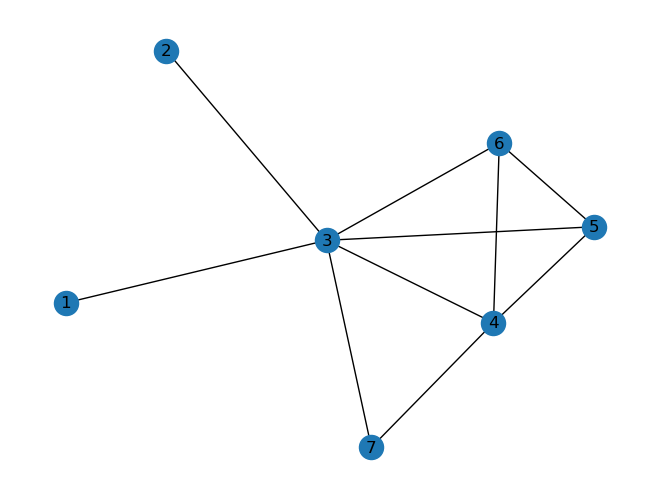

In [340]:
pcalg_skeleton(pcalg_samples, 0.05)

0.5915994922186918 1 2 [3, 4, 5, 6, 7] ()
0.7168643682747664 1 4 [3, 5, 6, 7] (3,)
0.7440101751686727 1 5 [3, 6, 7] (3,)
0.7631596517041546 1 6 [3, 7] (3,)
0.37188007522208366 1 7 [3] (3,)
0.9667137306683309 2 4 [3, 5, 6, 7] (3,)
0.646641122625403 2 5 [3, 6, 7] (3,)
0.7641450369853025 2 6 [3, 7] (3,)
0.754024450607707 2 7 [3] (3,)
0.9835341595250047 6 7 [3, 4, 5] (3, 4)
11


(<networkx.classes.graph.Graph at 0x7f884ff65fd0>,
 {(1, 2): (),
  (1, 4): (3,),
  (1, 5): (3,),
  (1, 6): (3,),
  (1, 7): (3,),
  (2, 4): (3,),
  (2, 5): (3,),
  (2, 6): (3,),
  (2, 7): (3,),
  (6, 7): (3, 4)})

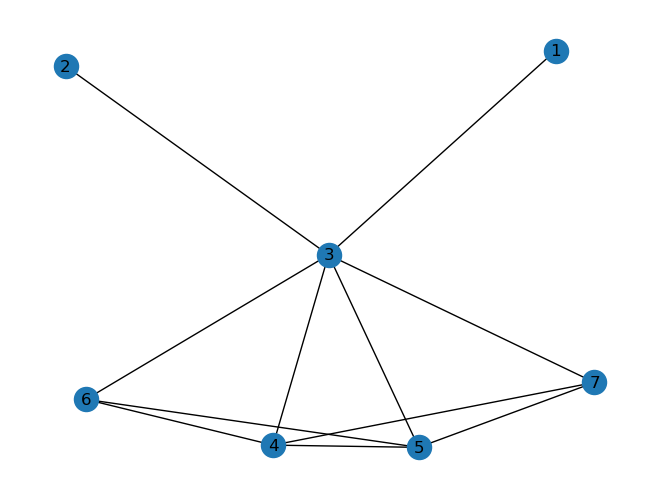

In [348]:
pcalg_skeleton(pcalg_samples[:500], 0.2)

In [349]:
compute_partial_correlation(pcalg_samples[:500], 1, 2, ())

-0.02406154807602445

0.5915994922186918 1 2 [3, 4, 5, 6, 7] ()
0.7168643682747664 1 4 [3, 5, 6, 7] (3,)
0.7440101751686727 1 5 [3, 6, 7] (3,)
0.7631596517041546 1 6 [3, 7] (3,)
0.37188007522208366 1 7 [3] (3,)
0.9667137306683309 2 4 [3, 5, 6, 7] (3,)
0.646641122625403 2 5 [3, 6, 7] (3,)
0.7641450369853025 2 6 [3, 7] (3,)
0.754024450607707 2 7 [3] (3,)
0.008670136008755547 3 4 [1, 2, 5, 6, 7] (7,)
0.10834766021222464 5 7 [3, 4, 6] (3, 4)
0.9835341595250047 6 7 [3, 4, 5] (3, 4)
9


(<networkx.classes.graph.Graph at 0x7f884ff65610>,
 {(1, 2): (),
  (1, 4): (3,),
  (1, 5): (3,),
  (1, 6): (3,),
  (1, 7): (3,),
  (2, 4): (3,),
  (2, 5): (3,),
  (2, 6): (3,),
  (2, 7): (3,),
  (3, 4): (7,),
  (5, 7): (3, 4),
  (6, 7): (3, 4)})

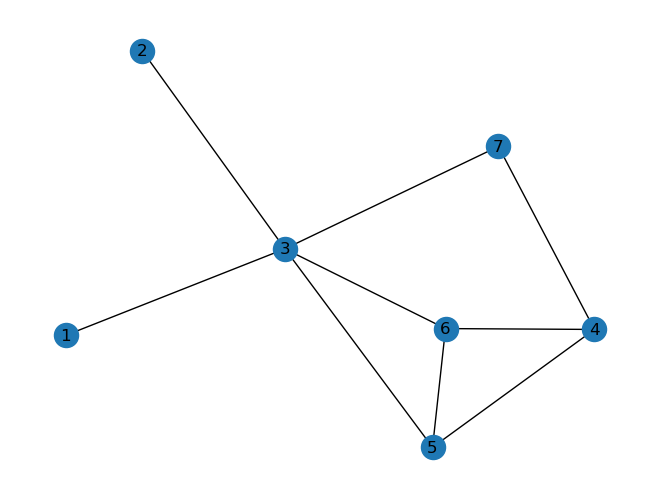

In [350]:
pcalg_skeleton(pcalg_samples[:500], 0.001)

## Orientation phase

In [367]:
def pcalg_orient(G, s):
    G_dir = G.to_directed()
    nx.draw(G_dir, with_labels=True)
    unshielded = []
    for k in G_dir.nodes:
        neighbors = [n for n in G_dir.neighbors(k)]
        
        if len(neighbors) < 2:
            continue
            
        else:
            print(k)
            colliders = list(itertools.combinations(neighbors, 2))
            print(colliders)
            
            for i, j in colliders:
                if not G_dir.has_edge(i, j):
                    if k in s[(i, j)]:
                        if G_dir.has_edge(i,k):
                            G_dir.remove_edge(i,k)
                            G_dir.remove_edge(k,i)
                        if G_dir.has_edge(j,k):
                            G_dir.remove_edge(j,k)
                            G_dir.remove_edge(k,j)
                    else:
                        unshielded.append((i, k, j))
                        G_dir.remove_edge(k,j)
                        G_dir.remove_edge(k,i)
        
                        
    return unshielded

In [369]:
def pcalg_orient(G, s):
    unshielded = []
    for k in G.nodes:
        neighbors = [n for n in G.neighbors(k)]
        
        if len(neighbors) < 2:
            continue
            
        else:
            print(k)
            colliders = list(itertools.combinations(neighbors, 2))
            print(colliders)
            
            for i, j in colliders:
                if not G.has_edge(i, j):
                    if k not in s[(i, j)]:
                        unshielded.append((i, k, j))        
                        
    return unshielded

In [373]:
estimated_skeleton, estimated_separator_function = pcalg_skeleton(pcalg_samples, 0.05)

pcalg_orient(estimated_skeleton, estimated_separator_function)

0.6345076834091419 1 2 [3, 4, 5, 6, 7] ()
0.571641900254436 1 4 [3, 5, 6, 7] (3,)
0.8998562127790861 1 5 [3, 6, 7] (3,)
0.9136382822840565 1 6 [3, 7] (3,)
0.4528538449507491 1 7 [3] (3,)
0.2367391980573017 2 4 [3, 5, 6, 7] (3,)
0.44991440107581493 2 5 [3, 6, 7] (3,)
0.4321206059027274 2 6 [3, 7] (3,)
0.9572079730489296 2 7 [3] (3,)
0.39010095342696394 5 7 [3, 4, 6] (3, 4)
0.6799503236776396 6 7 [3, 4, 5] (3, 4)
10
3
[(1, 2), (1, 4), (1, 5), (1, 6), (1, 7), (2, 4), (2, 5), (2, 6), (2, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]
4
[(3, 5), (3, 6), (3, 7), (5, 6), (5, 7), (6, 7)]
5
[(3, 4), (3, 6), (4, 6)]
6
[(3, 4), (3, 5), (4, 5)]
7
[(3, 4)]


[(1, 3, 2)]

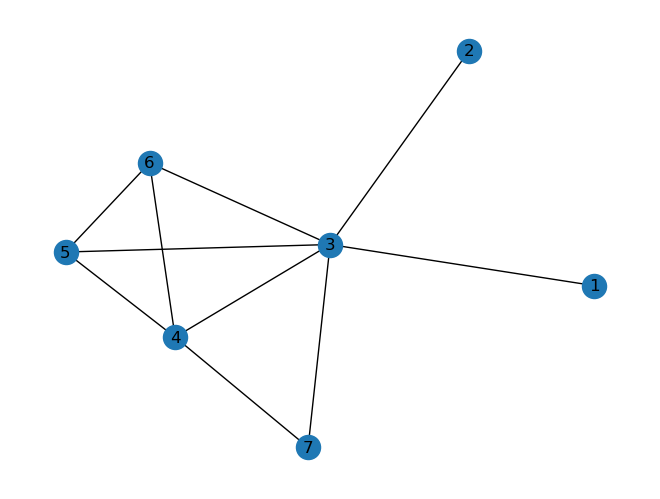

In [374]:
nx.draw(estimated_skeleton, with_labels=True)

In [ ]:
def pcalg_orient(G, s):
    G_dir = G.to_directed()
    nx.draw(G_dir, with_labels=True)
    unshielded = []
    for k in G_dir.nodes:
        neighbors = [n for n in G_dir.neighbors(k)]
        
        if len(neighbors) < 2:
            continue
            
        else:
            print(k)
            colliders = list(itertools.combinations(neighbors, 2))
            print(colliders)
            
            for i, j in colliders:
                if not G_dir.has_edge(i, j):
                    if k in s[(i, j)]:
                        if G_dir.has_edge(i,k):
                            G_dir.remove_edge(i,k)
                            G_dir.remove_edge(k,i)
                        if G_dir.has_edge(j,k):
                            G_dir.remove_edge(j,k)
                            G_dir.remove_edge(k,j)
                    else:
                        unshielded.append((i, k, j))
                        G_dir.remove_edge(k,j)
                        G_dir.remove_edge(k,i)
        
                        
    return unshielded